# Import libraries

Import required libraries and initialize Stockfish engine

TODO: re-write engines to use chess.engine instead, so we can use lc0 with Maia weights as well

In [45]:
import chess
import chess.pgn
import os
import math
from stockfish import Stockfish

stockfish = Stockfish(os.path.join('bin', 'stockfish_14_x64'))

# Load pgns

In [46]:
LIMIT = 50 # max number of games to load

In [47]:
pgn = open(os.path.join('data', 'lichess_db_standard_rated_2013-01.pgn'))
games = []
for _ in range(LIMIT):
    game = chess.pgn.read_game(pgn)
    games.append(game)
print(len(games))

50


# Define pipeline functions

* Calculate value of a piece
* Get Stockfish evaluations of tactic move suggestions
* Get top-n Stockfish move suggestions for a given board position
* Evaluate the move suggestions from a tactic against Stockfish suggestions using DCG (discounted
  cumulative gain)


In [48]:
def value(piece_type):
    king_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 99
    }
    return king_values[piece_type]

In [49]:
ray_piece_types = [chess.QUEEN, chess.ROOK, chess.BISHOP]

def is_defended(board, piece, square) -> bool:
    if board.attackers(piece.color, square):
        return True
    # ray defense https://lichess.org/editor/6k1/3q1pbp/2b1p1p1/1BPp4/rp1PnP2/4PRNP/4Q1P1/4B1K1_w_-_-_0_1
    for attacker in board.attackers(not piece.color, square):
        attacker_piece = board.piece_at(attacker)
        assert(attacker_piece)
        if attacker_piece.piece_type in ray_piece_types:
            bc = board.copy(stack = False)
            bc.remove_piece_at(attacker)
            if bc.attackers(piece.color, square):
                return True

    return False

def is_hanging(board, piece, square) -> bool:
    return not is_defended(board, piece, square)


In [50]:
def behind(a, b):
    whole_ray = chess.SquareSet.ray(a, b)
    b_first = False
    for square in whole_ray:
        if square == b:
            b_first = True
            break
        if square == a:
            b_first = False
            break
    if b_first:
        for square in reversed(list(whole_ray)):
            whole_ray.discard(square)
            if square == b:
                break
        partial_ray = reversed(list(whole_ray))
    else:
        for square in whole_ray:
            whole_ray.discard(square)
            if square == b:
                break
        partial_ray = whole_ray
    return list(partial_ray)

In [51]:
def get_evals(engine, board, suggestions):
    evals = []
    previous_board_fen = engine.get_fen_position()
    for suggested_move in suggestions:
        board.push(suggested_move)
        engine.set_fen_position(board.fen())
        evaluation = engine.get_evaluation()
        evals.append((evaluation['type'], evaluation['value']))
        board.pop()
    engine.set_fen_position(previous_board_fen)
    return evals

In [52]:
def get_top_n_moves(engine, n, board):
    previous_board_fen = engine.get_fen_position()
    engine.set_fen_position(board.fen())
    top_n_moves = engine.get_top_moves(n)
    engine.set_fen_position(previous_board_fen)
    return top_n_moves

In [53]:
def evaluate(evaluated_suggestions, top_moves):
    dcg = 0
    for idx, (evaluated_move, top_move) in enumerate(zip(evaluated_suggestions, top_moves)):
        # print(evaluated_move, top_move)
        if evaluated_move[1][0] == 'cp':
            eval = evaluated_move[1][1]
        elif evaluated_move[1][0] == 'mate':
            eval = 2000
        top_eval = top_move['Centipawn'] if not top_move['Mate'] else 2000
        dcg += abs(top_eval - eval) / math.log2(1 + (idx + 1))
    return dcg

# Define tactic heuristics

## Fork

### Pattern

if a non-king piece can move to a square where it attacks more than 1 piece of greater value than a pawn

### Suggestion

suggest the moves where the condition holds

In [54]:
def fork(board):
    match = False
    suggestions = []
    for move in board.legal_moves:
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type == chess.KING:
            continue
        board.push(move)
        board.push(chess.Move.null())
        nb = 0
        # print(move, chess.square_name(move.to_square), board.attacks(move.to_square))
        for attacks in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacks)
            # print(chess.square_name(attacks), attacked_piece, value(attacked_piece))
            if attacked_piece is None or attacked_piece.color == board.turn:
                continue
            if attacked_piece.piece_type == chess.PAWN:
                continue
            if value(attacked_piece.piece_type) > value(moved_piece_type) or (
                is_hanging(board, attacked_piece, attacks) and
                attacks not in board.attackers(not board.turn, move.to_square)
            ):
                nb += 1
        board.pop()
        board.pop()
        if nb > 1:
            match = True
            suggestions.append(move)
    suggestions = list(set(suggestions))
    return match, suggestions[:3]

## Skewer

### Pattern

if a sliding piece can be moved to a square where it attacks a piece of higher value and
simultaneously x-rays an unsupported piece of lower value

### Suggestion

suggest moves where the condition holds


In [57]:
def skewer(board):
    match = False
    suggestions = []
    # print(board)
    # print(board.legal_moves)
    for move in board.legal_moves:
        # print(move)
        moved_piece_type = board.piece_type_at(move.from_square)
        if moved_piece_type not in ray_piece_types:
            continue
        board.push(move)
        board.push(chess.Move.null())
        if not board.is_valid():
            board.pop()
            board.pop()
            continue
        for attacked_square in board.attacks(move.to_square):
            attacked_piece = board.piece_at(attacked_square)
            if attacked_piece is None or attacked_piece.color == board.turn:
                continue
            # if piece immediately "behind" attacked piece is of opponent color and of lower value
            # than attacked piece, then match
            partial_ray = behind(move.to_square, attacked_square)
            # print(partial_ray)
            for square in partial_ray:
                if (xrayed_piece := board.piece_at(square)) is not None:
                    if (
                        xrayed_piece.color != board.turn and # opponent color
                        is_hanging(board, xrayed_piece, square) and # unsupported
                        value(xrayed_piece.piece_type) < value(attacked_piece.piece_type) # lesser value
                    ):
                        match = True
                        suggestions.append(move)
                    break
        board.pop()
        board.pop()
    suggestions = list(set(suggestions))
    return match, suggestions[:3]

# Calculate metrics for all games

In [56]:
total = 0  # total number of games
matches = 0 # number of matches found in a position across all games
total_dcg = 0
for game in games:
    board = game.board()
    total += 1
    for move in game.mainline_moves():
        board.push(move)
        match, suggestions = skewer(board)
        if match:
            matches += 1
            evals = get_evals(stockfish, board, suggestions)
            evaluated_suggestions = zip(suggestions, evals)
            top_n_moves = get_top_n_moves(stockfish, len(suggestions), board)
            # print(board.fen(), evaluated_suggestions, top_n_moves)
            total_dcg += evaluate(evaluated_suggestions, top_n_moves)
            
print(f'Coverage = {matches / total}') # average number of matches per game
print(f'Total DCG = {total_dcg}')

[58]
[60]
[53, 62]
[60]
[63]
[51, 58]
[62]
[61]
[]
[20, 13, 6]
[2]
[5]
[18, 9, 0]
[]
[6]
[4]
[7]
[27, 26, 25, 24]
[]
[60]
[53, 62]
[60]
[63]
[51, 58]
[62]
[61]
[61]
[]
[57]
[]
[]
[]
[]
[20, 13, 6]
[2]
[]
[5]
[18, 9, 0]
[]
[6]
[4]
[7]
[27, 26, 25, 24]
[21, 14, 7]
[]
[58]
[60]
[53, 62]
[60]
[63]
[51, 58]
[62]
[61]
[61]
[]
[57]
[]
[]
[]
[]
[20, 13, 6]
[]
[11, 4]
[2]
[]
[5]
[18, 9, 0]
[]
[6]
[4]
[7]
[27, 26, 25, 24]
[21, 14, 7]
[]
[21, 14, 7]
[1]
[7]
[58]
[60]
[53, 62]
[55, 63]
[60]
[51, 58]
[62]
[61]
[]
[61]
[]
[]
[]
[57]
[]
[]
[]
[]
[]
[]
[20, 13, 6]
[]
[11, 4]
[2]
[]
[5]
[18, 9, 0]
[]
[6]
[]
[4]
[7]
[27, 26, 25, 24]
[55, 63]
[21, 14, 7]
[]
[21, 14, 7]
[1]
[7]
[58]
[60]
[53, 62]
[55, 63]
[60]
[51, 58]
[61]
[]
[]
[6]
[18, 9, 0]
[]
[]
[]
[]
[20, 13, 6]
[]
[11, 4]
[2]
[]
[5]
[18, 9, 0]
[6]
[4]
[7]
[27, 26, 25, 24]
[21, 14, 7]
[5]
[21, 14, 7]
[1]
[7]
[58]
[60]
[60]
[51, 58]
[53, 62]
[47]
[47]
[18, 9, 0]
[]
[]
[]
[]
[20, 13, 6]
[]
[11, 4]
[2]
[21, 14, 7]
[21, 14, 7]
[1]
[7]
[22, 14, 6]
[18, 9

# Individual Test Position

A single constructed position for testing the fork heuristic

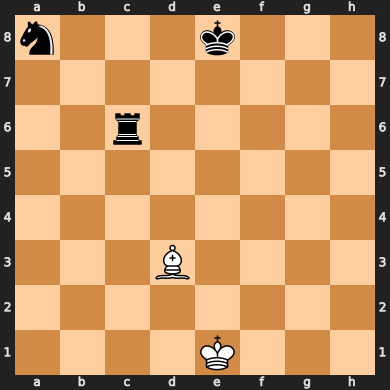

In [38]:
board = chess.Board('n3k3/8/2r5/8/8/3B4/8/4K3 w - - 0 1')
board

In [42]:
match, suggestions = skewer(board)
print(suggestions)
top_moves = get_top_n_moves(stockfish, len(suggestions), board)
print(top_moves)
if match:
    evals = get_evals(stockfish, board, suggestions)
    # print(board.fen(), match, list(zip(suggestions, evals)), top_moves)
print(evaluate(zip(suggestions, evals), top_moves))

n . . . k . . .
. . . . . . . .
. . r . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .
. . . . . . . .
. . . . K . . .
<LegalMoveGenerator at 0x7f15cc1d9850 (Bh7, Bg6+, Ba6, Bf5, Bb5, Be4, Bc4, Be2, Bc2, Bf1, Bb1, Kf2, Ke2, Kd2, Kf1, Kd1)>
d3h7
d3g6
d3a6
d3f5
d3b5
[51, 60]
d3e4
[49, 56]
d3c4
d3e2
d3c2
d3f1
d3b1
e1f2
e1e2
e1d2
e1f1
e1d1
[Move.from_uci('d3e4')]
[{'Move': 'd3b5', 'Centipawn': -18, 'Mate': None}]
5807.0
